In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams['figure.dpi'] = 100

In [3]:
import os

In [4]:
# leer los archivos
df = []
ndx = 0
nd = {}
total = 0

archivos = [x for x in os.listdir('merged_data') if x[-8:] == '.parquet' and '_ele_' in x]

for archivo in archivos:
    df.append(pd.read_parquet(f'merged_data/{archivo}'))
    ndx = len(df[-1].index)
    print(archivo, ndx)
    nd[archivo] = ndx
    total += ndx

print('Total datos:', total)

Cruce_Adatrap_Ttec_ele_F41 00I.parquet 34747
Cruce_Adatrap_Ttec_ele_F46 00R.parquet 94463
Cruce_Adatrap_Ttec_ele_F41 00R.parquet 33902
Cruce_Adatrap_Ttec_ele_F48 00I.parquet 88734
Cruce_Adatrap_Ttec_ele_F46 00I.parquet 82264
Cruce_Adatrap_Ttec_ele_F53 E0 00R.parquet 20140
Cruce_Adatrap_Ttec_ele_F53 E0 00I.parquet 26021
Cruce_Adatrap_Ttec_ele_F46 02I.parquet 13477
Cruce_Adatrap_Ttec_ele_F48 00R.parquet 73527
Total datos: 467275


In [5]:
# unir todos los dias leidos en un dataframe
df = pd.concat(df)
print('Data total:', len(df.index))

Data total: 467275


In [6]:
# la data de potencia esta separada en consumida y gastada, sacar el neto
df['valor_pot_forw'] = df['valor_ptc_forw'] + df['valor_ptg_forw']
df['valor_pot_back'] = df['valor_ptc_back'] + df['valor_ptg_back']

In [7]:
# hay error de redondeo en adatrap, asignar estos numeros negativos de perfil a 0 
fix_pfc = ((df['Perfil_carga_al_llegar'] < 0) & (df['Perfil_carga_al_llegar'] > - 1))
df.loc[fix_pfc, 'Perfil_carga_al_llegar'] = 0

In [8]:
df.sort_values(by=['Patente', 'Fecha', 'Identificador_expedición_día', 'Hora_en_parada', 'Secuencia_parada'], inplace=True)

# se realiza interpolacion lineal de la data tracktec, usando dato tracktec antecesor y sucesor al timestamp en parada adatrap
df['dT_ttec'] = (df['fecha_hora_evento_forw'] - df['fecha_hora_evento_back']) / pd.Timedelta(seconds=1)
df['dT_back_A'] = (df['Hora_en_parada'] - df['fecha_hora_evento_back']) / pd.Timedelta(seconds=1)
df['dT_forw_A'] = (df['fecha_hora_evento_forw'] - df['Hora_en_parada']) / pd.Timedelta(seconds=1)
df['dP'] = (df['valor_pot_forw'] - df['valor_pot_back'])
df['Pot_en_parada'] = df['valor_pot_back'] + (df['dT_back_A'] * df['dP'] / df['dT_ttec'])

df['dSoc'] = (df['valor_soc_forw'] - df['valor_soc_back'])
df['Soc_en_parada'] = df['valor_soc_back'] + (df['dT_back_A'] * df['dSoc'] / df['dT_ttec'])

# asumir temperaturas como promedio simple de dato tracktec antecesor y sucesor
df['Temp_ext'] = (df['valor_text_forw'] + df['valor_text_back']) * 0.5
df['Temp_int'] = (df['valor_tint_forw'] + df['valor_tint_back']) * 0.5

# rellenear aquellos que no necesitan interpolacion (dT_ttec==0)
check_relleno_back = (df['Hora_en_parada'] == df['fecha_hora_evento_back'])
check_relleno_forw = (df['Hora_en_parada'] == df['fecha_hora_evento_forw'])

df.loc[check_relleno_forw, 'Pot_en_parada'] = df.loc[check_relleno_forw, 'valor_pot_forw']
df.loc[check_relleno_back, 'Pot_en_parada'] = df.loc[check_relleno_back, 'valor_pot_back']

df.loc[check_relleno_forw, 'Soc_en_parada'] = df.loc[check_relleno_forw, 'valor_soc_forw']
df.loc[check_relleno_back, 'Soc_en_parada'] = df.loc[check_relleno_back, 'valor_soc_back']

In [9]:
# nota: para identificar una expedicion unica se debe usar tupla id_ppu_fecha
# sacar min y max del n° id de secuencia de los paraderos visitados por expedicion (a usarse despues)
min_max_secuencia = df.groupby(['Patente', 'Fecha', 'Identificador_expedición_día']).agg({'Secuencia_parada': ['min', 'max']})
min_max_secuencia['min_secuencia'] = min_max_secuencia['Secuencia_parada']['min']
min_max_secuencia['max_secuencia'] = min_max_secuencia['Secuencia_parada']['max']
min_max_secuencia = min_max_secuencia[['min_secuencia', 'max_secuencia']]
min_max_secuencia = min_max_secuencia.reset_index()
min_max_secuencia = min_max_secuencia.droplevel(level=1, axis=1)

df = df.merge(min_max_secuencia,
              on=['Patente', 'Fecha', 'Identificador_expedición_día'],
              suffixes=('', '_mm'))


In [10]:
# boolean si registro es inicio o fin de expedicion
check_fin_inicio_exp = ((df['Secuencia_parada'] == df['max_secuencia']) | (df['Secuencia_parada'] == df['min_secuencia']))
# revisar si hay paraderos seguidos con el mismo dato tracktec imputado
# en cada fila ver el antecesor (hacia atras), y filtrar las que no cumplen, por eso shift(1) y no shift(-1)
check_fhback_df = (df['fecha_hora_evento_back'] != df['fecha_hora_evento_back'].shift(1))
check_fhforw_df = (df['fecha_hora_evento_forw'] != df['fecha_hora_evento_forw'].shift(1))

# revisar que el pulso ttec posterior sea distinto al pulso ttec previo de siguiene fila?
# check_fh_cruce_df = (df['fecha_hora_evento_back'] != df['fecha_hora_evento_forw'].shift(1))

# revisar que data Ttec antecesor y sucesor no este muy alejada entre sí, se vió histograma y este es punto eficiente
check_dt_ttec = (df['dT_ttec'] < 130)
check_fh_cruce = (check_dt_ttec & check_fhback_df & check_fhforw_df) # & check_fh_cruce_df)

In [11]:
# ver si estaba bien interpolar, para esto se revisa la data tracktec con los check definidos anteriormente
df['check_interpolar'] = 0
df.loc[(check_fin_inicio_exp | check_fh_cruce), 'check_interpolar'] = 1

# antes de filtrarlos, se calcula promedio ponderado (por distancia) de la carga de tramos que se van a eliminar
df['dX'] = df['Distancia_parada_desde_inicio_ruta'].shift(-1) - df['Distancia_parada_desde_inicio_ruta']
df['id_carga_interp'] =df['check_interpolar'].cumsum()
df['dist_por_carga'] =df['dX'] * df['Perfil_carga_al_llegar']
df_carga_interp = df.groupby('id_carga_interp')[['dist_por_carga', 'dX', 'Subidas_expandidas', 'Bajadas_expandidas']].sum()
df_carga_interp.rename(columns={'Subidas_expandidas': 'Subidas_total_interp', 'Bajadas_expandidas': 'Bajadas_total_interp'}, inplace=True)

df_carga_interp['Carga_pond'] = df_carga_interp['dist_por_carga'] / df_carga_interp['dX']
df_carga_interp = df_carga_interp[['Carga_pond', 'Subidas_total_interp', 'Bajadas_total_interp']]
df = df.merge(df_carga_interp,
              left_on="id_carga_interp",
              right_index=True, suffixes=('', ''))

df['Perfil_carga_al_llegar'] = df['Carga_pond']
df['Subidas_expandidas'] = df['Subidas_total_interp']
df['Bajadas_expandidas'] = df['Bajadas_total_interp']

df = df.loc[df['check_interpolar'] == 1]
df.drop(columns=['Carga_pond', 'Subidas_total_interp', 'Bajadas_total_interp'], inplace=True)
print('Datos con data tracktec valida:', len(df.index))

Datos con data tracktec valida: 226483


In [12]:
df['dX'] = df['Distancia_parada_desde_inicio_ruta'].shift(-1) - df['Distancia_parada_desde_inicio_ruta']

In [13]:
# ahora se busca tener solo filas con detencion entre tramos, es decir que alguien suba o baje y no siga de largo
check_se_detiene = ((df['Subidas_expandidas'] != 0) | (df['Bajadas_expandidas'] != 0))
check_fin_inicio_exp = ((df['Secuencia_parada'] == df['max_secuencia']) | (df['Secuencia_parada'] == df['min_secuencia']))

# sin embargo, se busca evitar registros alejados por más de 20km
# que no hayan mas de 20 km sin datos antes de filtrar
# para esto, el algoritmo encuentra un punto a 5km desde inicio del filtrado, y mantiene ese punto
max_tramo = 20000
corte_tramo = 5000

df['check_se_detiene'] = 0
df.loc[(check_fin_inicio_exp | check_se_detiene), 'check_se_detiene'] = 1

In [14]:
if False:
    # hacer esto tres veces para cortar tres veces tramos de más de 5km
    for i in range(3):
        print('Iteracion', i)
        if i >= 0:
            # si es la segunda iteración, botar columnas de iteración previa
            df.drop(columns=['dacum_max', 'dacum_min'], inplace=True)

        # esto identifica tramos de registros entre detenciones a filtrar al asignarles un mismo id
        df['id_se_detiene'] = df['check_se_detiene'].cumsum()

        # encontrar min y max de distancia acumulada en estos tramos por filtrar
        df_gb = df.groupby('id_se_detiene')[['Distancia_parada_desde_inicio_ruta']].min()
        df_gb.rename(columns={'Distancia_parada_desde_inicio_ruta': 'dacum_min'}, inplace=True)

        df_gb2 = df.groupby('id_se_detiene')[['Distancia_parada_desde_inicio_ruta']].max()
        df_gb2.rename(columns={'Distancia_parada_desde_inicio_ruta': 'dacum_max'}, inplace=True)
        df_gb['dacum_max'] = df_gb2['dacum_max']
        df = df.merge(df_gb,
                      left_on="id_se_detiene",
                      right_index=True, suffixes=('', ''))

        # se define la distancia acumulada en estos tramos tomando la distancia del <primer paradero del tramo> como el origen
        df['dacum'] = df['Distancia_parada_desde_inicio_ruta'] - df['dacum_min']
        df['dacum_max'] = df['dacum_max'] - df['dacum_min']

        # buscar primer registro que sobrepase los 5km y mantener ese registro
        dfx = df.loc[((df['dacum'] > corte_tramo) & (df['check_se_detiene'] == 0)), ['id_se_detiene', 'Secuencia_parada']].copy()
        dfx.drop_duplicates(subset=['id_se_detiene'], keep='first', inplace=True)
        df['quiza_se_detiene'] = False
        df.loc[dfx.index, 'quiza_se_detiene'] = True
        check_suponer_detencion = (df['quiza_se_detiene'] & ((df['dacum_max'] > max_tramo) & (df['dacum_max'] - df['dacum'] > 1000)))
        # reasignar como una detencion este punto a 5km que se iba a filtrar
        df.loc[check_suponer_detencion, 'check_se_detiene'] = 1

In [15]:
if False:
    # esto identifica tramos de registros entre detenciones a filtrar al asignarles un mismo id
    df['id_se_detiene'] = df['check_se_detiene'].cumsum()

    # encontrar min y max de distancia acumulada en estos tramos por filtrar
    df_gb = df.groupby('id_se_detiene')[['Distancia_parada_desde_inicio_ruta']].min()
    df_gb.rename(columns={'Distancia_parada_desde_inicio_ruta': 'dacum_min'}, inplace=True)

    df_gb2 = df.groupby('id_se_detiene')[['Distancia_parada_desde_inicio_ruta']].max()
    df_gb2.rename(columns={'Distancia_parada_desde_inicio_ruta': 'dacum_max'}, inplace=True)
    df_gb['dacum_max'] = df_gb2['dacum_max']
    df = df.merge(df_gb,
                  left_on="id_se_detiene",
                  right_index=True, suffixes=('', ''))

    df['dacum_max'] = df['dacum_max'] - df['dacum_min']

    # hay una condicion de borde que no se cumple al tener registros que pueden ser justo el final de un tramo largo filtrado
    # y cuyo siguiente registro presente un salto enorme en distancia
    check_condicion_de_borde = (((df['dacum_max'] > 1000) & (df['dX'] > 20000)))
    df.loc[check_condicion_de_borde, 'check_se_detiene'] = 1

In [16]:
dfo = df.copy()

In [17]:
df = df.loc[df['check_se_detiene'] == 1]
print('Datos entre detenciones:', len(df.index))

Datos entre detenciones: 110403


In [18]:
# sacar expediciones con menos de 4 datos
conteo_por_exp = df.groupby(['Patente', 'Fecha', 'Identificador_expedición_día']).agg({'Patente': ['count']})

conteo_por_exp['conteo'] = conteo_por_exp['Patente']['count']
conteo_por_exp = conteo_por_exp[['conteo']]
conteo_por_exp = conteo_por_exp.reset_index()
conteo_por_exp = conteo_por_exp.droplevel(level=1, axis=1)

df = df.merge(conteo_por_exp,
              on=['Patente', 'Fecha', 'Identificador_expedición_día'],
              suffixes=('', '_c'))

df = df.loc[df['conteo'] > 3]
print('Expediciones con más de 3 datos:', len(df.index))

Expediciones con más de 3 datos: 105991


In [19]:
df['fin_o_ini'] = ((df['Secuencia_parada'] == df['max_secuencia']) | (df['Secuencia_parada'] == df['min_secuencia']))
df_alt = pd.read_excel('data/Altimetria_Paradas_Red.xlsx', engine='openpyxl')
df_buses = pd.read_excel('data/buses_inventario.xlsx', engine='openpyxl')

In [20]:
col_final = ['Patente', 'Servicio_transantiago', 'Cumplimiento', 'Capacidad_bus', 'Código_parada_usuario', 'fin_o_ini',
             'Secuencia_parada',  'Identificador_expedición_día', 'Distancia_parada_desde_inicio_ruta', 'Subidas_expandidas',
             'Bajadas_expandidas', 'Perfil_carga_al_llegar', 'Fecha', 'Hora_en_parada', 'Pot_en_parada', 'Soc_en_parada',
             'Zona_paga', 'Temp_ext', 'Temp_int', 'valor_soc_back']

In [21]:
# juntar con datos de altimetria por parada
data_final = df[col_final].merge(df_alt[['Altitud', 'Codigo parada']],
                                       left_on="Código_parada_usuario",
                                       right_on="Codigo parada", suffixes=('', ''))


data_final = data_final.loc[data_final['Cumplimiento'] == 'C']
data_final = data_final.loc[~data_final['Altitud'].isna()]
data_final.sort_values(by=['Patente', 'Fecha', 'Identificador_expedición_día', 'Hora_en_parada', 'Secuencia_parada'], inplace=True)

# juntar con datos de marca y modelo por patente de bus
data_final = data_final.merge(df_buses, left_on="Patente",
                              right_on="PPU1", suffixes=('', ''))

# sacar delta en trayecto entre apradas
data_final['dT'] = (data_final['Hora_en_parada'].shift(-1) - data_final['Hora_en_parada']) / pd.Timedelta(seconds=1)
data_final['dX'] = data_final['Distancia_parada_desde_inicio_ruta'].shift(-1) - data_final['Distancia_parada_desde_inicio_ruta']
data_final['dP'] = data_final['Pot_en_parada'].shift(-1) - data_final['Pot_en_parada']
data_final['dSoc'] = data_final['Soc_en_parada'].shift(-1) - data_final['Soc_en_parada']
data_final['dA'] = data_final['Altitud'].shift(-1) - data_final['Altitud']

# filtrar datos invalidos por secuencia
check_pfc = (data_final['Perfil_carga_al_llegar'] >= 0)
# check_se_detiene = ((data_final['Subidas_expandidas'] != 0) | (data_final['Bajadas_expandidas'] != 0))
check_ppu = (data_final['Patente'] == data_final['Patente'].shift(-1))
check_fecha = (data_final['Fecha'] == data_final['Fecha'].shift(-1))
check_id_exp = (data_final['Identificador_expedición_día'] == data_final['Identificador_expedición_día'].shift(-1))
check_secuencia_parada = ((data_final['Secuencia_parada'].shift(-1) - data_final['Secuencia_parada']) >= 1)

data_final = data_final.loc[(check_pfc & check_ppu & check_fecha & check_id_exp & check_secuencia_parada & (~data_final['fin_o_ini']))]

# filtrar datos invalidos por valor
print('Data preprocesada:', len(data_final.index))
data_final = data_final.loc[data_final['dX'] > 0]
print('Data dX > 0:', len(data_final.index))
data_final = data_final.loc[data_final['dT'] > 0]
print('Data dT > 0:', len(data_final.index))
data_final = data_final.loc[data_final['dP'] > 0]
print('Data dP > 0:', len(data_final.index))
data_final = data_final.loc[data_final['dSoc'] < 0]
print('Data dSoc < 0:', len(data_final.index))

print('Data total:', len(df.index))
print('Data procesada:', len(data_final.index))

Data preprocesada: 86380
Data dX > 0: 86380
Data dT > 0: 86329
Data dP > 0: 85999
Data dSoc < 0: 78969
Data total: 105991
Data procesada: 78969


In [22]:
# df = pd.DataFrame()

In [23]:
data_final.loc[data_final['Terminal'] != 'Juanita', 'Terminal'] = 'Maipú'

data_final['dT'] = data_final['dT'] / 60
data_final['dA_original'] = data_final['dA']
data_final['dA'] = 100 * data_final['dA'] / data_final['dX']
data_final['dX'] = data_final['dX'] / 1000
data_final['dP'] = data_final['dP'] / 1000
data_final['Vel'] = 60 * data_final['dX'] / data_final['dT']
data_final['Pot_km'] = data_final['dP'] / data_final['dX']

print('Data procesada:', len(data_final.index))
data_final = data_final.loc[data_final['Vel'] < 80]
print('Vel < 80 km/hr:', len(data_final.index))
data_final = data_final.loc[data_final['Vel'] > 1]
print('Vel > 1 km/hr:', len(data_final.index))
data_final = data_final.loc[data_final['Pot_km'] < 10]
print('Potencia/distancia < 10 kWh/km:', len(data_final.index))

data_final.rename(columns={'Perfil_carga_al_llegar': 'Carga', 'valor_soc_back': 'Soc_ini'}, inplace=True)

Data procesada: 78969
Vel < 80 km/hr: 78949
Vel > 1 km/hr: 78948
Potencia/distancia < 10 kWh/km: 78932


In [24]:
data_final['km_por_kwh'] = data_final['dX'] / data_final['dP']

In [25]:
variables = ['dX', 'dT', 'Vel', 'dA', 'Carga', 'dA_original', 'Soc_ini', 'dP', 'dSoc', 'Pot_km', 'km_por_kwh']
corr = data_final[variables].corr(method ='kendall') # parecido a spearman va entre 0 y 1
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,dX,dT,Vel,dA,Carga,dA_original,Soc_ini,dP,dSoc,Pot_km,km_por_kwh
dX,1.00,0.78,0.16,-0.03,-0.15,0.01,-0.01,0.70,-0.65,-0.16,0.16
dT,0.78,1.00,-0.07,-0.03,-0.14,0.01,-0.04,0.70,-0.65,-0.07,0.07
Vel,0.16,-0.07,1.00,-0.01,-0.06,0.00,0.06,0.04,-0.02,-0.25,0.25
dA,-0.03,-0.03,-0.01,1.00,-0.01,0.71,0.07,0.15,-0.11,0.41,-0.41
Carga,-0.15,-0.14,-0.06,-0.01,1.00,-0.02,0.07,-0.12,0.11,0.08,-0.08
dA_original,0.01,0.01,0.00,0.71,-0.02,1.00,0.07,0.19,-0.15,0.36,-0.36
Soc_ini,-0.01,-0.04,0.06,0.07,0.07,0.07,1.00,-0.01,0.03,0.03,-0.03
dP,0.70,0.70,0.04,0.15,-0.12,0.19,-0.01,1.00,-0.73,0.14,-0.14
dSoc,-0.65,-0.65,-0.02,-0.11,0.11,-0.15,0.03,-0.73,1.00,-0.08,0.08
Pot_km,-0.16,-0.07,-0.25,0.41,0.08,0.36,0.03,0.14,-0.08,1.00,-1.00


In [26]:
data_juanita = data_final.loc[data_final['Terminal'] == 'Juanita'].copy()

In [27]:
corrj = data_juanita[variables].corr(method ='kendall') # parecido a spearman va entre 0 y 1
corrj.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,dX,dT,Vel,dA,Carga,dA_original,Soc_ini,dP,dSoc,Pot_km,km_por_kwh
dX,1.00,0.78,0.16,-0.06,-0.10,0.04,-0.02,0.64,-0.60,-0.15,0.15
dT,0.78,1.00,-0.06,-0.04,-0.14,0.04,-0.04,0.65,-0.60,-0.07,0.07
Vel,0.16,-0.06,1.00,-0.03,0.08,-0.01,0.05,0.02,-0.02,-0.25,0.25
dA,-0.06,-0.04,-0.03,1.00,-0.00,0.58,-0.11,0.20,-0.18,0.51,-0.51
Carga,-0.10,-0.14,0.08,-0.00,1.00,-0.01,0.08,-0.10,0.10,0.03,-0.03
dA_original,0.04,0.04,-0.01,0.58,-0.01,1.00,-0.15,0.30,-0.28,0.46,-0.46
Soc_ini,-0.02,-0.04,0.05,-0.11,0.08,-0.15,1.00,-0.08,0.09,-0.12,0.12
dP,0.64,0.65,0.02,0.20,-0.10,0.30,-0.08,1.00,-0.78,0.21,-0.21
dSoc,-0.60,-0.60,-0.02,-0.18,0.10,-0.28,0.09,-0.78,1.00,-0.18,0.18
Pot_km,-0.15,-0.07,-0.25,0.51,0.03,0.46,-0.12,0.21,-0.18,1.00,-1.00


Text(0.5, 1.0, 'Data Tracktec-Adatrap Noviembre 2020')

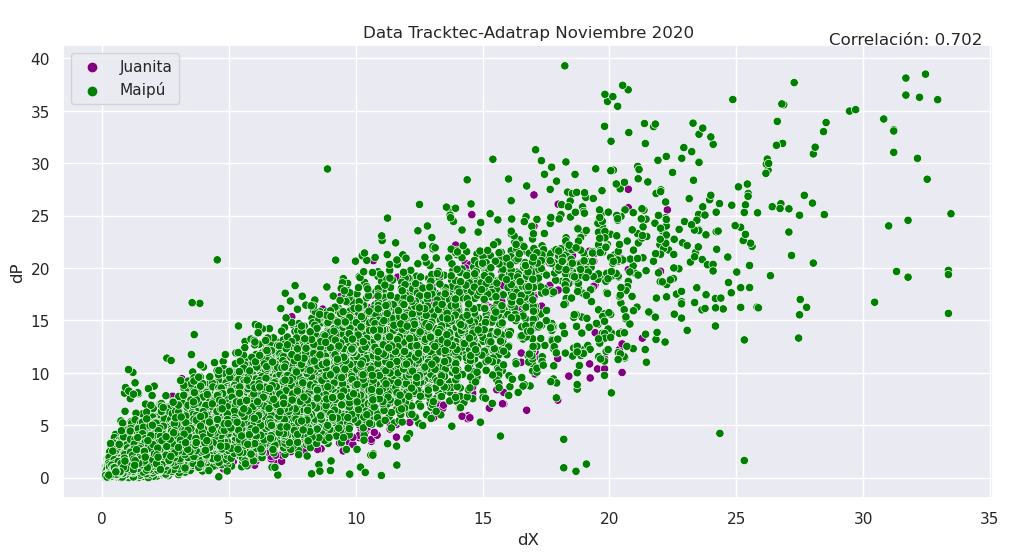

In [28]:
palette ={"Juanita": "purple", "Maipú": "green"}
varx = 'dX'
vary = 'dP'
sns.scatterplot(data=data_final,
                x=varx, y=vary,
                hue='Terminal', palette=palette)

plt.legend(loc='upper left')

plt.annotate(f"Correlación: {round(corr[varx][vary], 3)}",
             xy=(0.8, 0.94), xycoords='figure fraction',
             horizontalalignment='left', verticalalignment='top', fontsize=12)

plt.title('Data Tracktec-Adatrap Noviembre 2020')
# plt.xlabel('Pendiente [%]')
# plt.ylabel('Potencia por km [kWh / km]')

Text(0.5, 1.0, 'Data Tracktec-Adatrap Noviembre 2020')

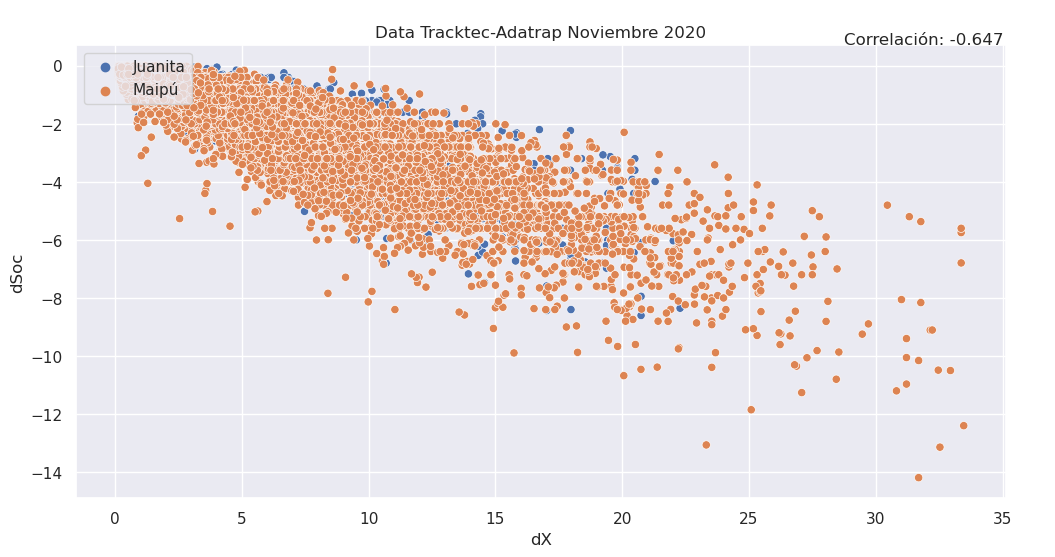

In [29]:
palette ={"Juanita": "purple", "Maipú": "green"}
varx = 'dX'
vary = 'dSoc'
sns.scatterplot(data=data_final,
                x=varx, y=vary,
                hue='Terminal')

plt.legend(loc='upper left')

plt.annotate(f"Correlación: {round(corr[varx][vary], 3)}",
             xy=(0.8, 0.94), xycoords='figure fraction',
             horizontalalignment='left', verticalalignment='top', fontsize=12)

plt.title('Data Tracktec-Adatrap Noviembre 2020')
# plt.xlabel('Pendiente [%]')
# plt.ylabel('Potencia por km [kWh / km]')


Text(0.5, 1.0, 'Data Tracktec-Adatrap Noviembre 2020')

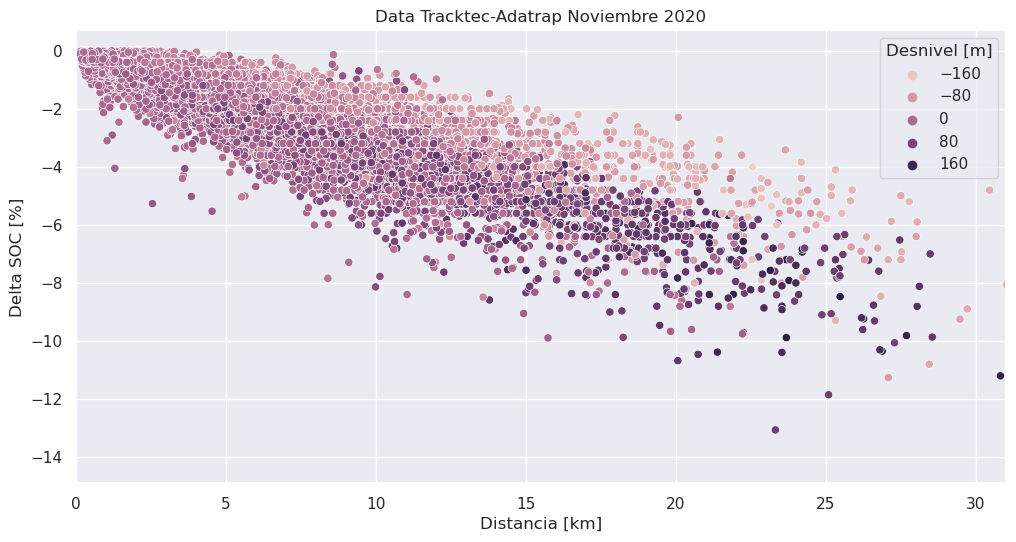

In [30]:
varx = 'dX'
vary = 'dSoc'
sns.scatterplot(data=data_final,
                x=varx, y=vary,
                hue='dA_original')


plt.xlabel('Distancia [km]')
plt.ylabel('Delta SOC [%]')
plt.legend(title='Desnivel [m]')
plt.xlim(0,31)
plt.title('Data Tracktec-Adatrap Noviembre 2020')

Text(0, 0.5, 'Potencia por km [kWh / km]')

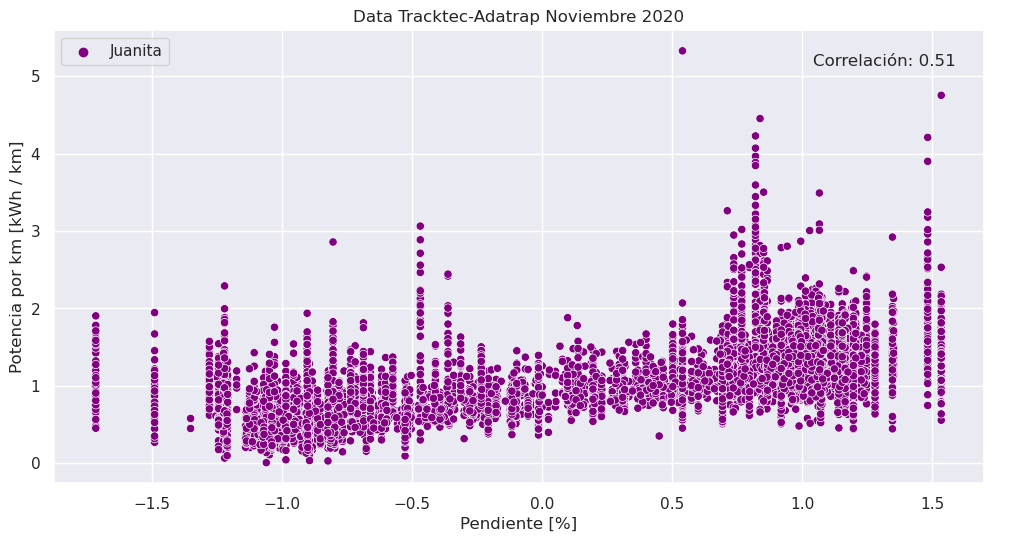

In [31]:
palette ={"Juanita": "purple", "Maipú": "green"}
varx = 'dA'
vary = 'Pot_km'
sns.scatterplot(data=data_juanita,
                x=varx, y=vary,
                hue='Terminal', palette=palette)

plt.legend(loc='upper left')

plt.annotate(f"Correlación: {round(corrj[varx][vary], 3)}",
             xy=(0.8, 0.9), xycoords='figure fraction',
             horizontalalignment='left', verticalalignment='top', fontsize=12)

plt.title('Data Tracktec-Adatrap Noviembre 2020')
plt.xlabel('Pendiente [%]')
plt.ylabel('Potencia por km [kWh / km]')

In [59]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [60]:
results = smf.ols('dP ~ dX - 1', data=data_final).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                     dP   R-squared (uncentered):                   0.882
Model:                            OLS   Adj. R-squared (uncentered):              0.882
Method:                 Least Squares   F-statistic:                          3.973e+05
Date:                Thu, 29 Apr 2021   Prob (F-statistic):                        0.00
Time:                        21:09:15   Log-Likelihood:                     -1.1767e+05
No. Observations:               53207   AIC:                                  2.353e+05
Df Residuals:                   53206   BIC:                                  2.353e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [54]:
results = smf.ols('dP ~ dSoc - 1', data=data_final.loc[data_final['Terminal'] == 'Maipú']).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                     dP   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.964
Method:                 Least Squares   F-statistic:                          1.174e+06
Date:                Thu, 29 Apr 2021   Prob (F-statistic):                        0.00
Time:                        20:15:52   Log-Likelihood:                         -72504.
No. Observations:               44005   AIC:                                  1.450e+05
Df Residuals:                   44004   BIC:                                  1.450e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [55]:
results = smf.ols('dP ~ dSoc - 1', data=data_juanita).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                     dP   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          1.370e+06
Date:                Thu, 29 Apr 2021   Prob (F-statistic):                        0.00
Time:                        20:16:03   Log-Likelihood:                         -5616.7
No. Observations:                9202   AIC:                                  1.124e+04
Df Residuals:                    9201   BIC:                                  1.124e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

(0.0, 3.0)

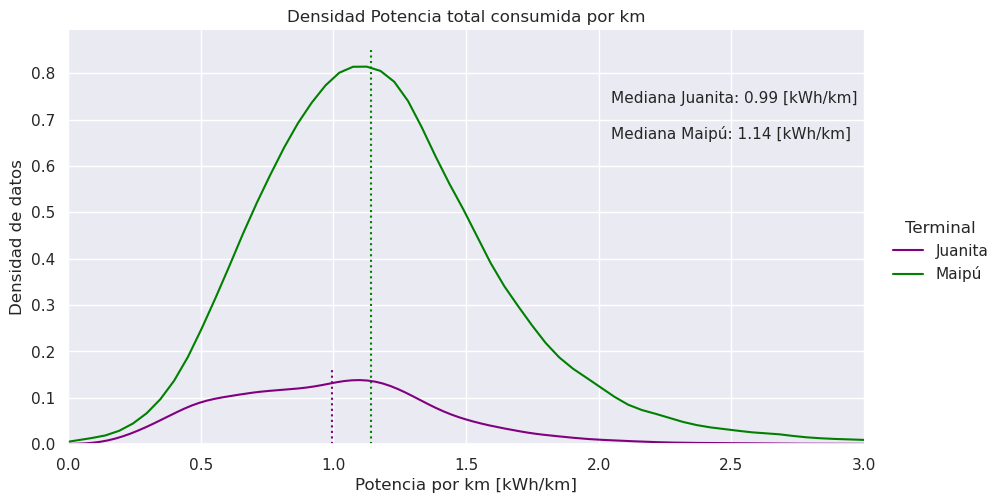

In [32]:
mediana_j = data_final.loc[data_final['Terminal'] == 'Juanita', 'Pot_km'].quantile(0.5)
mediana_m = data_final.loc[data_final['Terminal'] == 'Maipú', 'Pot_km'].quantile(0.5)

g = sns.displot(data=data_final, x="Pot_km", hue="Terminal", kind="kde", aspect=18/10, palette=palette)

data_x, data_y = g.axes[0,0].get_lines()[1].get_data()
moda_j = data_x[np.argmax(data_y)]

data_x, data_y = g.axes[0,0].get_lines()[0].get_data()
moda_m = data_x[np.argmax(data_y)]



anotacion = (f"Mediana Juanita: {round(mediana_j, 2)} [kWh/km]\n"
             f"\n"
             f"Mediana Maipú: {round(mediana_m, 2)} [kWh/km]")

plt.vlines(mediana_j, 0, 0.165, color='purple', ls=':')
plt.vlines(mediana_m, 0, 0.85, color='green', ls=':')

plt.annotate(anotacion,
             xy=(0.61, 0.82), xycoords='figure fraction',
             horizontalalignment='left', verticalalignment='top', fontsize=11)

plt.ylabel('Densidad de datos')
plt.xlabel('Potencia por km [kWh/km]')
plt.title('Densidad Potencia total consumida por km')
plt.xlim(0,3)

In [ ]:
# ver si diferencia en promedio es significativo
from scipy.stats import ttest_ind
ttest, pvalt = ttest_ind(data_final.loc[data_final['Tipo_bus'] == 'Rigido', 'Cons_km'], data_final.loc[data_final['Tipo_bus'] == 'Oruga', 'Cons_km'], equal_var=False)
print(f"ttest_ind: t = {ttest}  p = {pvalt}")

In [ ]:
media_rigido = data_final.loc[data_final['Tipo_bus'] == 'Rigido', 'Cons_km'].mean()
media_oruga = data_final.loc[data_final['Tipo_bus'] == 'Oruga', 'Cons_km'].mean()
print("promedio rigidos:", media_rigido)
print("promedio orugas:", media_oruga)

Text(0.5, 1.0, 'dT_ttec')

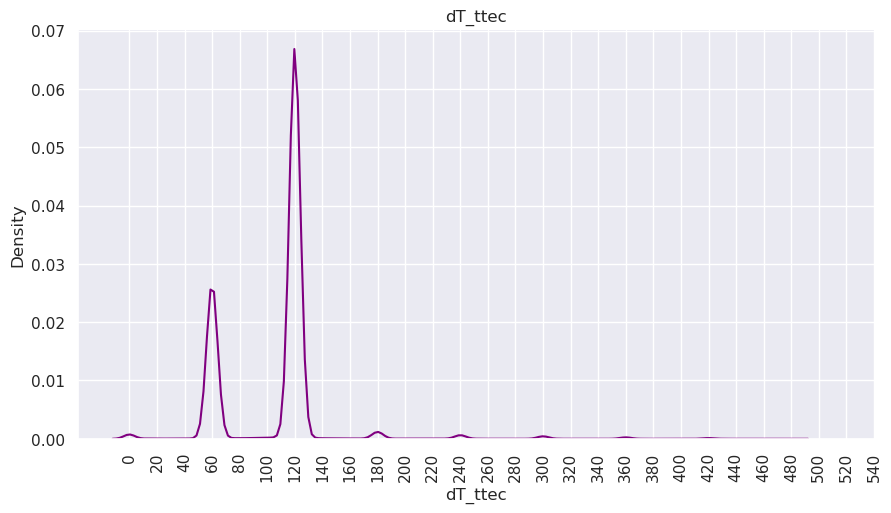

In [64]:
graf = sns.displot(data=df, x="dT_ttec", kind="kde", aspect=18/10, color='purple')
plt.xticks(range(0, 560, 20), rotation=90)
plt.title("dT_ttec")

Text(0.5, 1.0, 'dT_ttec')

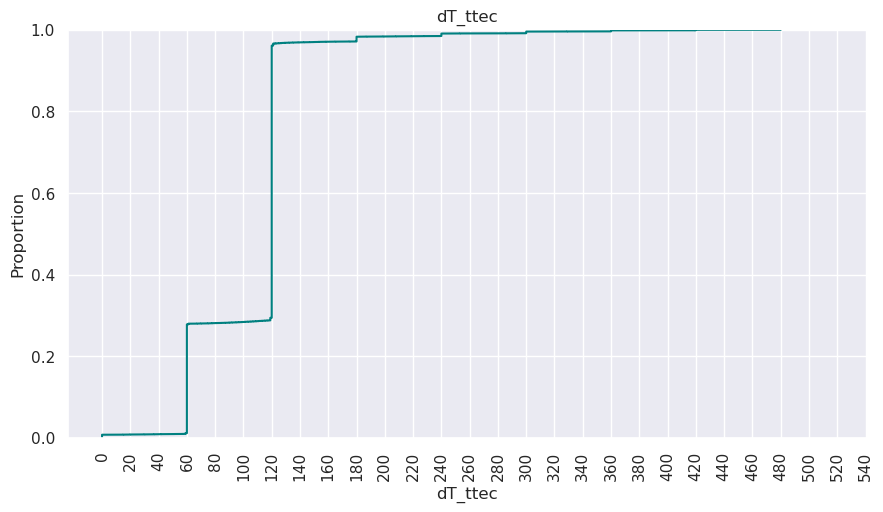

In [63]:
graf = sns.displot(data=df, x="dT_ttec", kind="ecdf", aspect=18/10, color='teal')
plt.xticks(range(0, 560, 20), rotation=90)
plt.title("dT_ttec")

Text(0.5, 1.0, 'dX (data final)')

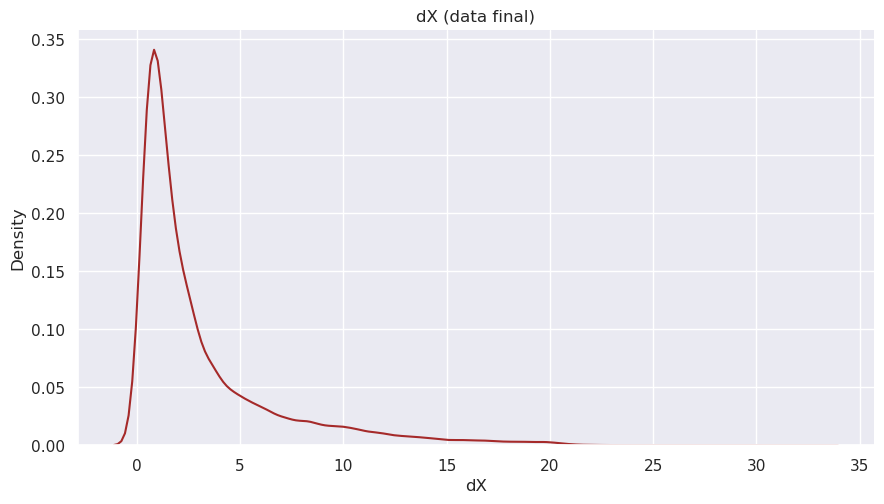

In [65]:
variable = 'dX'
graf = sns.displot(data=data_final, x=variable, kind="kde", aspect=18/10, color='brown')
plt.title(f"{variable} (data final)")

<AxesSubplot:xlabel='dauxx', ylabel='Count'>

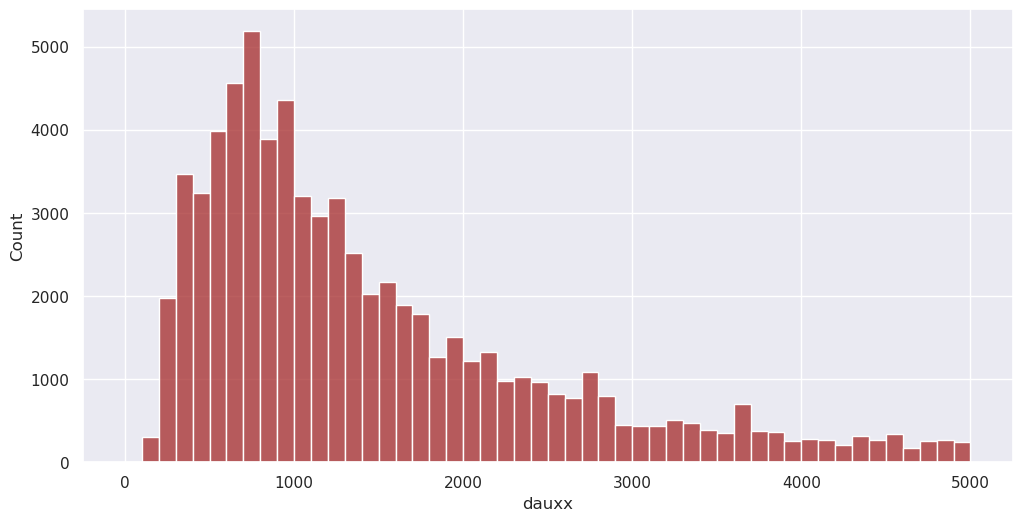

In [42]:
data_final['dauxx'] = data_final['dX'] * 1000
sns.histplot(data=data_final, x='dauxx', binwidth=100, binrange=[0, 5000], color='brown')

Text(0.5, 1.0, 'dT (data final)')

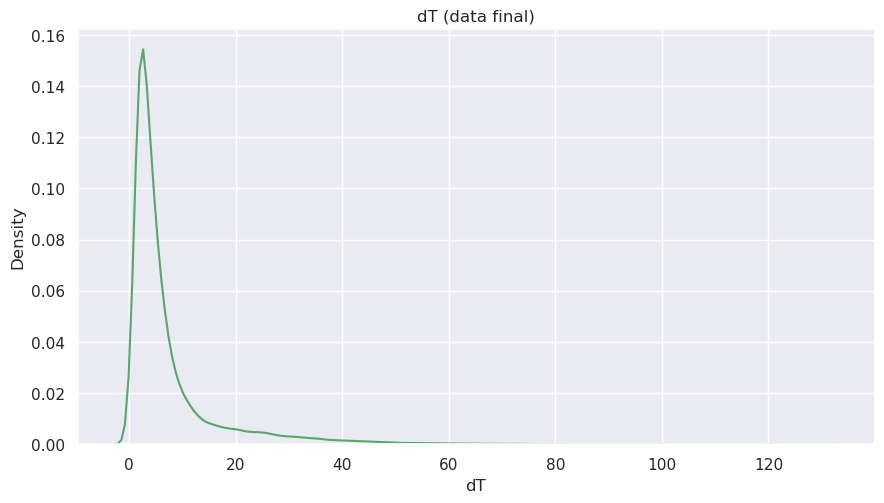

In [41]:
variable = 'dT'
graf = sns.displot(data=data_final, x=variable, kind="kde", aspect=18/10, color='g')
plt.title(f"{variable} (data final)")

<AxesSubplot:xlabel='dauxt', ylabel='Count'>

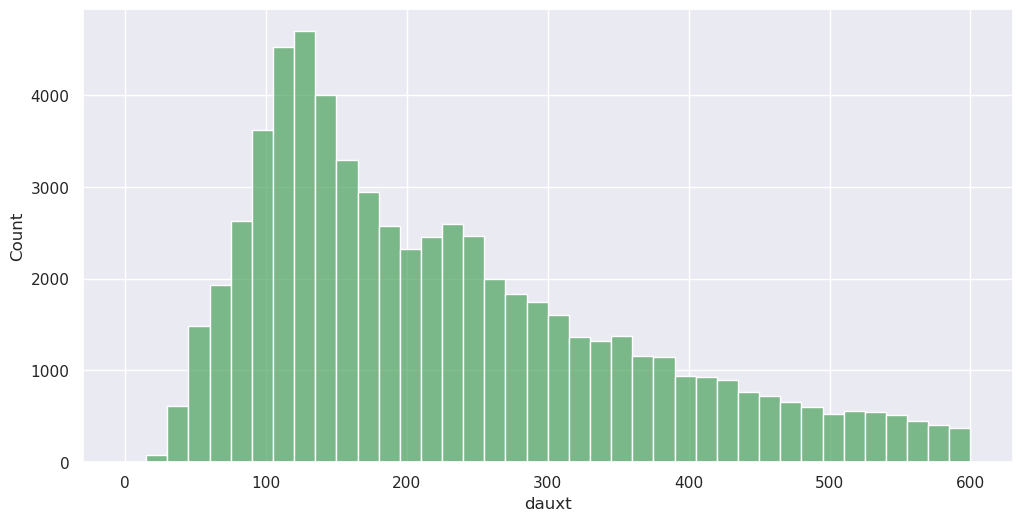

In [39]:
data_final['dauxt'] = data_final['dT'] * 60
sns.histplot(data=data_final, x='dauxt', binwidth=15, binrange=[0, 600], color='g')

Text(0.5, 1.0, 'dP (data final)')

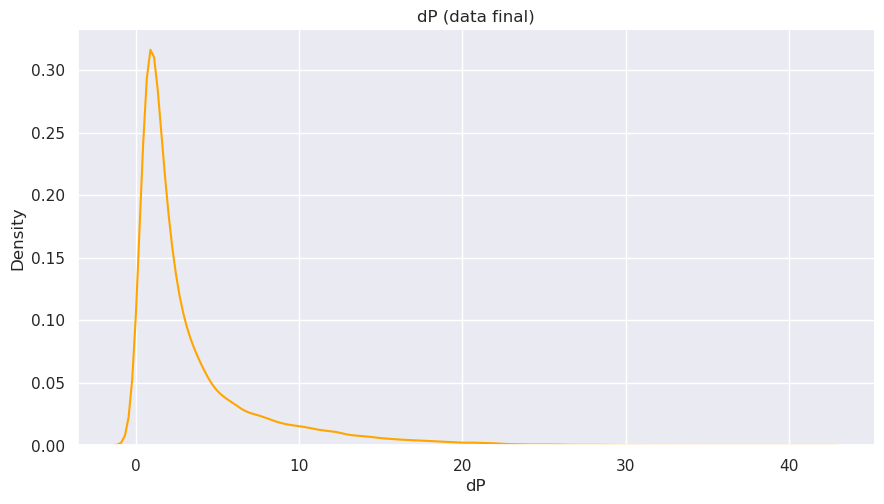

In [68]:
variable = 'dP'
graf = sns.displot(data=data_final, x=variable, kind="kde", aspect=18/10, color='orange')
plt.title(f"{variable} (data final)")

<AxesSubplot:xlabel='dP', ylabel='Count'>

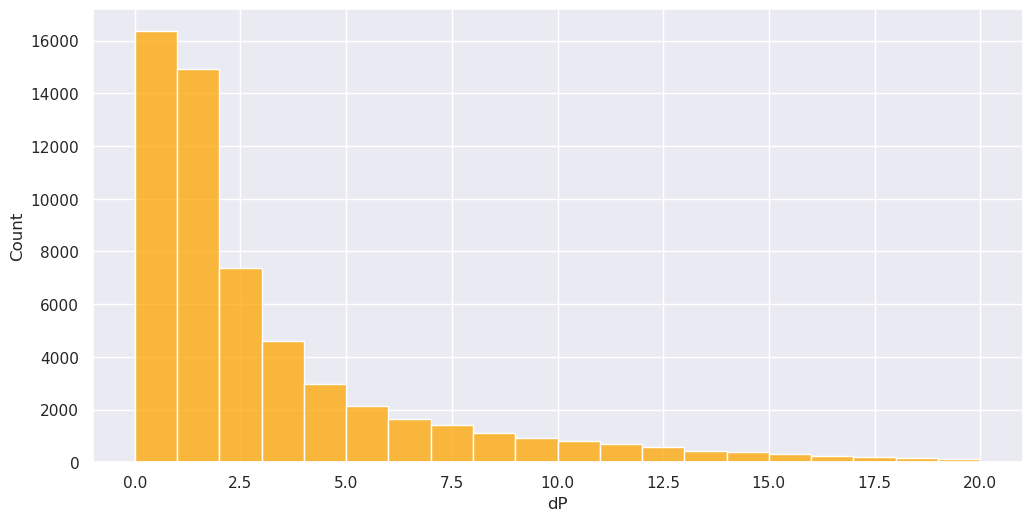

In [69]:
sns.histplot(data=data_final, x='dP', binwidth=1, binrange=[0, 20], color='orange')

Text(0.5, 1.0, 'dA (data final)')

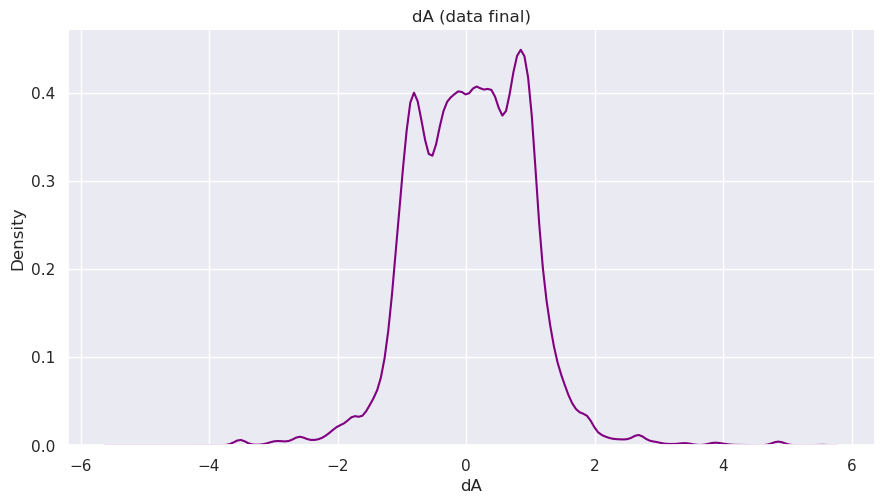

In [34]:
variable = 'dA'
graf = sns.displot(data=data_final, x=variable, kind="kde", aspect=18/10, color='purple')
plt.title(f"{variable} (data final)")

Text(0.5, 1.0, 'Carga (data final)')

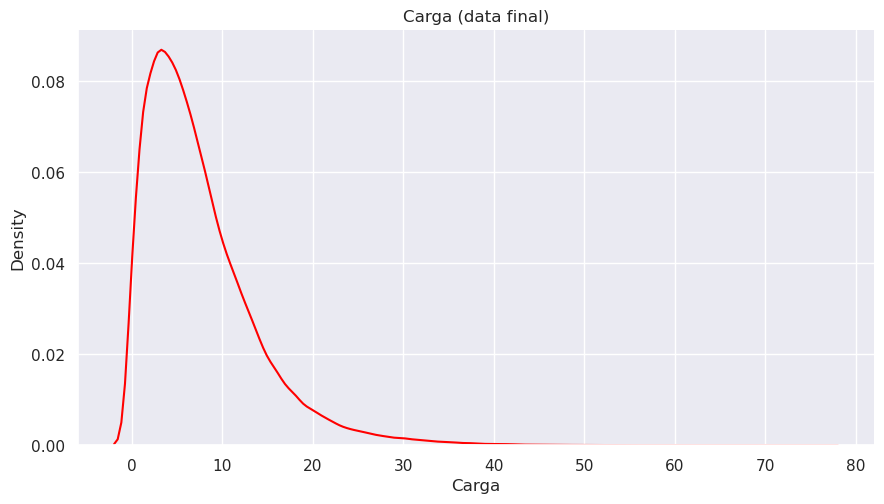

In [36]:
variable = 'Carga'
graf = sns.displot(data=data_final, x=variable, kind="kde", aspect=18/10, color='red')
plt.title(f"{variable} (data final)")

<AxesSubplot:xlabel='Carga', ylabel='Count'>

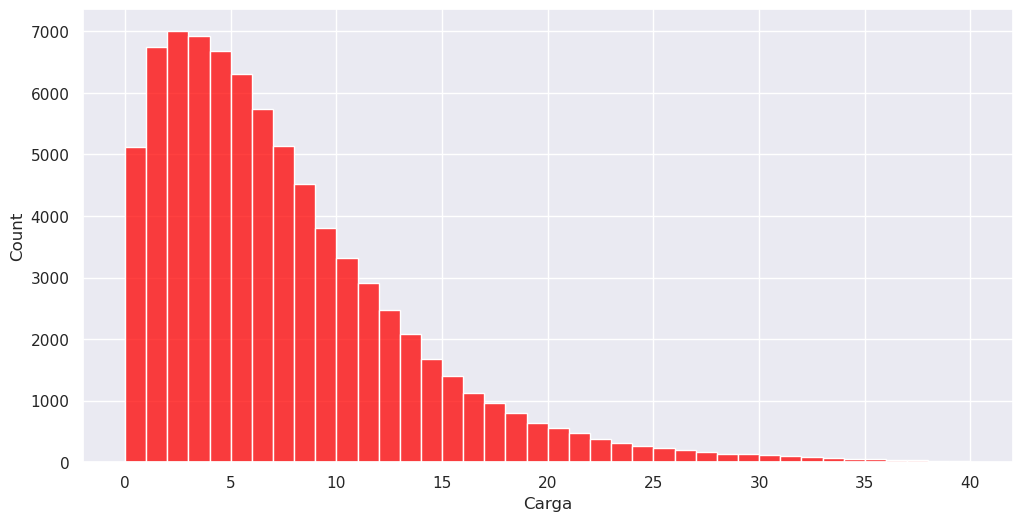

In [37]:
sns.histplot(data=data_final, x='Carga', binwidth=1, binrange=[0, 40], color='red')

Text(0.5, 1.0, 'Vel (data final)')

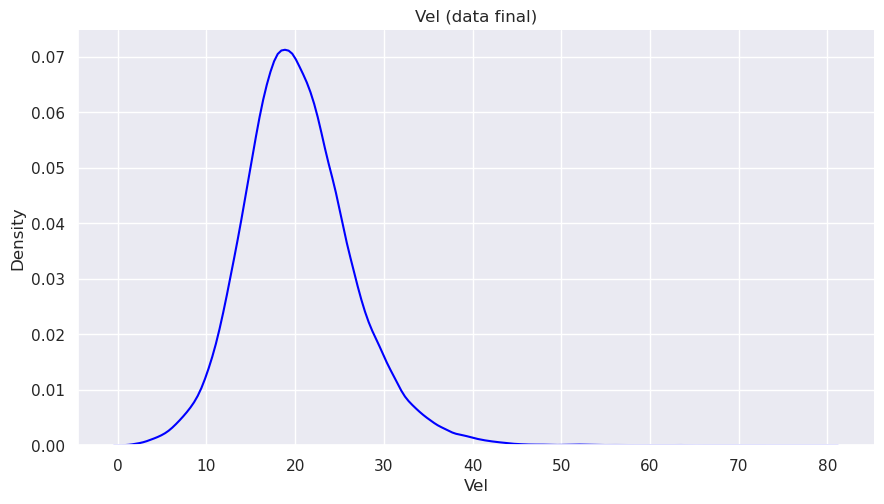

In [38]:
variable = 'Vel'
graf = sns.displot(data=data_final, x=variable, kind="kde", aspect=18/10, color='blue')
plt.title(f"{variable} (data final)")

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
# 'dX', 'dT', 'Vel', 'dA', 'Carga', 'Temp_parada', 'dC', 'Cons_km'

In [ ]:
ols_results = smf.ols('dC ~ dX + dT + dA', data=data_final).fit()
print(ols_results.summary())

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split# Split the data into training and testing sets
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor# Instantiate model with 1000 decision trees
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
features = data_final[['dX', 'dT', 'Vel', 'dA', 'Carga', 'dC']].copy()

In [ ]:
# Labels are the values we want to predict
labels = np.array(features['dC'])# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('dC', axis = 1)# Saving feature names for later use
feature_list = list(features.columns)# Convert to numpy array
features = np.array(features)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 31)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

# Baseline errors, and display average baseline error
baseline_errors = test_labels * 0.2
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

In [ ]:
rf = RandomForestRegressor(n_estimators = 500, random_state = 37, n_jobs=15)# Train the model on training data
rf.fit(train_features, train_labels);

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)# Calculate the absolute errors
%time

In [ ]:
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)

MAE = mean_absolute_error(test_labels, predictions)
print('MAE:', round(MAE, 2))

MSE = mean_squared_error(test_labels, predictions)
RMSE = np.sqrt(MSE)
print('RMSE:', round(RMSE, 2))

r_n = np.sqrt(test_labels.size)

print('Cota_sup_RMSE:', round(MAE * r_n, 2))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
printeo = [print('Variable: {:7} | Importance: {:.3f}'.format(*pair)) for pair in feature_importances]

In [ ]:
# Limit depth of tree to 4 levels
rf_small = RandomForestRegressor(n_estimators=1, max_depth = 6)
rf_small.fit(train_features, train_labels)# Extract the small tree

# Use the forest's predict method on the test data
predictions = rf_small.predict(test_features)# Calculate the absolute errors
errors = abs(predictions - test_labels)# Print out the mean absolute error (mae)
print('MAE:', round(np.mean(errors), 5))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 3), '%.')

tree_small = rf_small.estimators_[0]# Save the tree as a png image
export_graphviz(tree_small, out_file = 'data/small_tree.dot', feature_names = feature_list, rounded = True, precision = 3)
(graph, ) = pydot.graph_from_dot_file('data/small_tree.dot')
graph.write_png('data/small_tree.png')

In [ ]:
# Get numerical feature importances
importances = list(rf_small.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
printeo = [print('Variable: {:7} | Importance: {:.3f}'.format(*pair)) for pair in feature_importances]

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split

In [ ]:
features = data_final.loc[data_final['Tipo_bus'] == 'Oruga', ['dX', 'dT', 'Vel', 'dA', 'Carga', 'dC']].copy()
# Labels are the values we want to predict
labels = np.array(features['dC'])
# Remove the labels from the features
features= features.drop('dC', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 31)
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

# Baseline errors, and display average baseline error
baseline_errors = y_test * 0.2
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

In [ ]:
regr = ElasticNet(random_state=0, alpha=1)
regr.fit(X_train, y_train)

print("R^2: ", regr.score(X_test, y_test))

coef_dict = {}
coef_dict['intercept'] = regr.intercept_
for coef, feat in zip(regr.coef_, feature_list):
    coef_dict[feat] = coef

print(coef_dict)